In [1]:
import scanpy as sc
from anndata import AnnData

from grnndata import GRNAnnData, from_embeddings
from grnndata import utils

from scdataloader import Preprocessor as myPreprocessor
from bengrn import BenGRN, get_sroy_gt, get_perturb_gt

import os
import warnings
import sys
import numpy as np

sys.path.insert(0, "../")
from scgpt_helper import prepare_model, prepare_dataset, generate_embedding, generate_grn
import scgpt as scg
from scgpt.tasks import GeneEmbedding
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.utils import set_seed
from scgpt.tokenizer import tokenize_and_pad_batch
import torch


os.environ["KMP_WARNINGS"] = "off"
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

print(torch.cuda.is_available())
set_seed(42)


💡 connected lamindb: jkobject/scprint


/home/ml4ig1/Documents code/scGPT/mytests/../scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/home/ml4ig1/Documents code/scGPT/mytests/../scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")


True



## Step 1: Load fine-tuned model and dataset


### 1.1 Load fine-tuned model

We are going to load a fine-tuned model for the gene interaction analysis on
Adamson dataset. The fine-tuned model can be downloaded via this
[link](https://drive.google.com/drive/folders/1HsPrwYGPXm867_u_Ye0W4Ch8AFSneXAn).
The dataset will be loaded in the next step 1.2.

To reproduce the provided fine-tuned model. Please followw the integration
fin-tuning pipeline to fine-tune the pre-trained blood model on the Adamson
perturbation dataset. Note that in the fine-tuning stage, we did not perform
highly vairable gene selection but trained on the 5000+ genes present in the
Adamson dataset. This is to provide flexbility in the inference stage to
investigate changes in attention maps across different perturbation conditions.


In [3]:
model, vocab = prepare_model(model_dir="../save/scGPT_human")

Resume model from ../save/scGPT_human/best_model.pt, the model args will override the config ../save/scGPT_human/args.json.



In [2]:
mpreprocessor = myPreprocessor(is_symbol=True, force_preprocess=True, skip_validate=True,
                            do_postp=False, min_valid_genes_id=5000, min_dataset_size=64)

genes = torch.load(
    '../../scPRINT/data/temp/vbd8bavn/epoch=17-step=90000.ckpt'
#    '/pasteur/zeus/projets/p02/ml4ig_hot/Users/jkalfon/scprint_scale/o2uniqsx/checkpoints/epoch=18-step=133000.ckpt'
)['hyper_parameters']['genes']

In [4]:
CELLTYPES = [
"retinal rod cell",
"Mueller cell",
"amacrine cell",
"ON-bipolar cell",
"rod bipolar cell",
"retinal cone cell",
"retina horizontal cell",
"retinal ganglion cell",
"astrocyte",
"microglial cell",
]

MAXCELLS = 1024
NUM_GENES = 5000

In [5]:
adata = sc.read_h5ad('/home/ml4ig1/scprint/.lamindb/gNNpgpo6gATjuxTE7CCp.h5ad')
#adata = sc.read_h5ad('../../scPRINT/data/gNNpgpo6gATjuxTE7CCp.h5ad')
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(utils.TF), "isTF"] = True
adata

AnnData object with n_obs × n_vars = 51370 × 70116
    obs: 'biosample_id', 'donor_id', 'cell_type_ontology_term_id', 'organism_ontology_term_id', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'cell_type__custom', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'is_primary_data', 'age', 'self_reported_ethnicity_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'cell_culture', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'uid', 'symbol', 'ncbi_gene_ids', 'biotype', 'desc

In [6]:
import gc

scGPT - INFO - Filtering genes by counts ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Log1p transforming ...
scGPT - INFO - Binning data ...


100%|██████████| 205/205 [00:06<00:00, 33.17it/s]


base enrichment
Top central genes: []


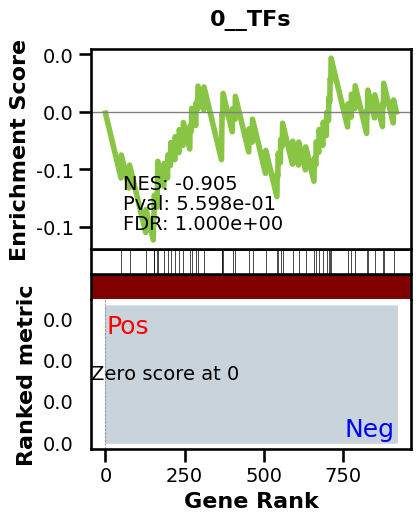

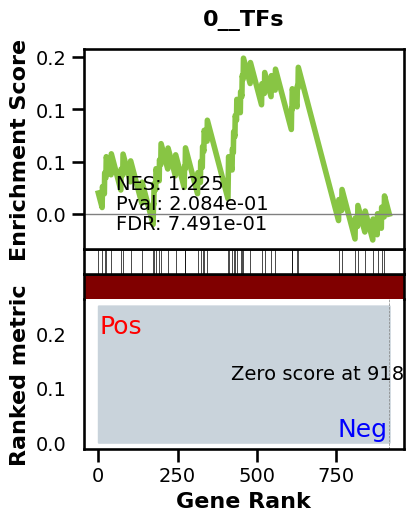

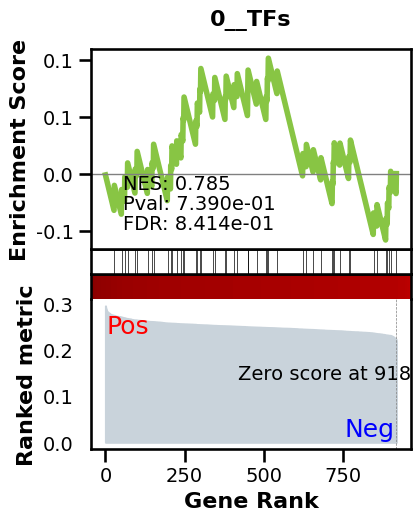

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath
intersection of 587 genes
intersection pct: 0.6387377584330794
precision:  0.0007864897886925406 
recall:  1.0 
random precision: 0.0007878319214377497


100%|██████████| 128/128 [00:00<00:00, 1480.60it/s]


Area Under Precision-Recall Curve (AUPRC):  0.0010305832723043434
EPR: 0.0


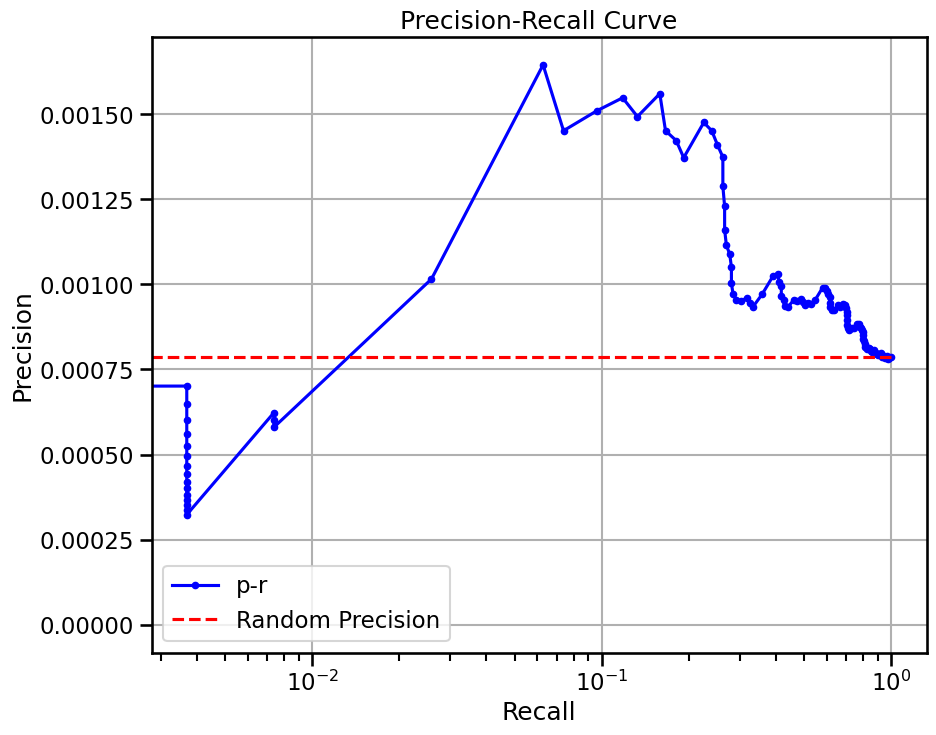

base enrichment
Top central genes: []


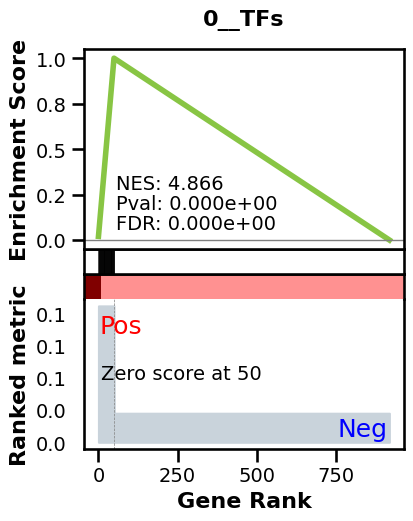

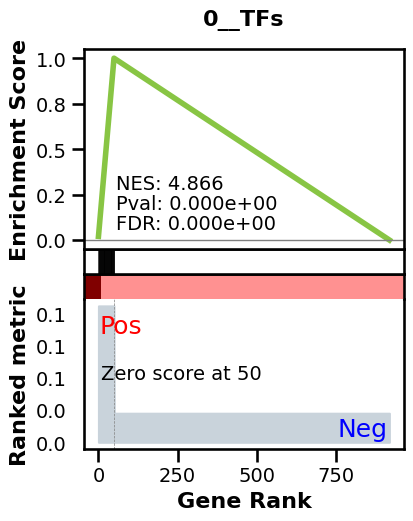

2024-07-02 13:34:59,346 [ERROR] No gene sets passed through filtering condition !!! 
Hint 1: Try to lower min_size or increase max_size !
Hint 2: Check gene symbols are identifiable to your gmt input.
Hint 3: Gene symbols curated in Enrichr web services are all upcases.

2024-07-02 13:34:59,348 [ERROR] The first entry of your gene_sets (gmt) look like this : { 0__TFs: [AC008770, AC023509, AC092835, AC138696, ADNP, ADNP2, AEBP1, AEBP2, AHCTF1, AHDC1, AHR, AHRR, AIRE, AKAP8, AKAP8L, AKNA, ALX1, ALX3, ALX4, ANHX, ANKZF1, AR, ARGFX, ARHGAP35, ARID2, ARID3A, ARID3B, ARID3C, ARID5A, ARID5B, ARNT, ARNT2, ARNTL, ARNTL2, ARX, ASCL1, ASCL2, ASCL3, ASCL4, ASCL5, ASH1L, ATF1, ATF2, ATF3, ATF4, ATF5, ATF6, ATF6B, ATF7, ATMIN, ATOH1, ATOH7, ATOH8, BACH1, BACH2, BARHL1, BARHL2, BARX1, BARX2, BATF, BATF2, BATF3, BAZ2A, BAZ2B, BBX, BCL11A, BCL11B, BCL6, BCL6B, BHLHA15, BHLHA9, BHLHE22, BHLHE23, BHLHE40, BHLHE41, BNC1, BNC2, BORCS8-MEF2B, BPTF, BRF2, BSX, C11orf95, CAMTA1, CAMTA2, CARF, CASZ1, CBX2, CC2

raised a lookup error


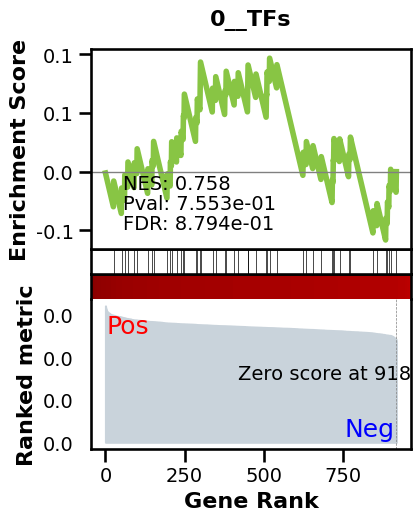

_________________________________________
TF specific enrichment
found some significant results for  66.66666666666667 % TFs

_________________________________________
loading GT,  omnipath
intersection of 587 genes
intersection pct: 0.6387377584330794
precision:  0.005719153078607934 
recall:  0.5202952029520295 
random precision: 0.0007878319214377497


100%|██████████| 128/128 [00:00<00:00, 1307.32it/s]


Area Under Precision-Recall Curve (AUPRC):  0.005335114997087407
EPR: 9.492461408769918


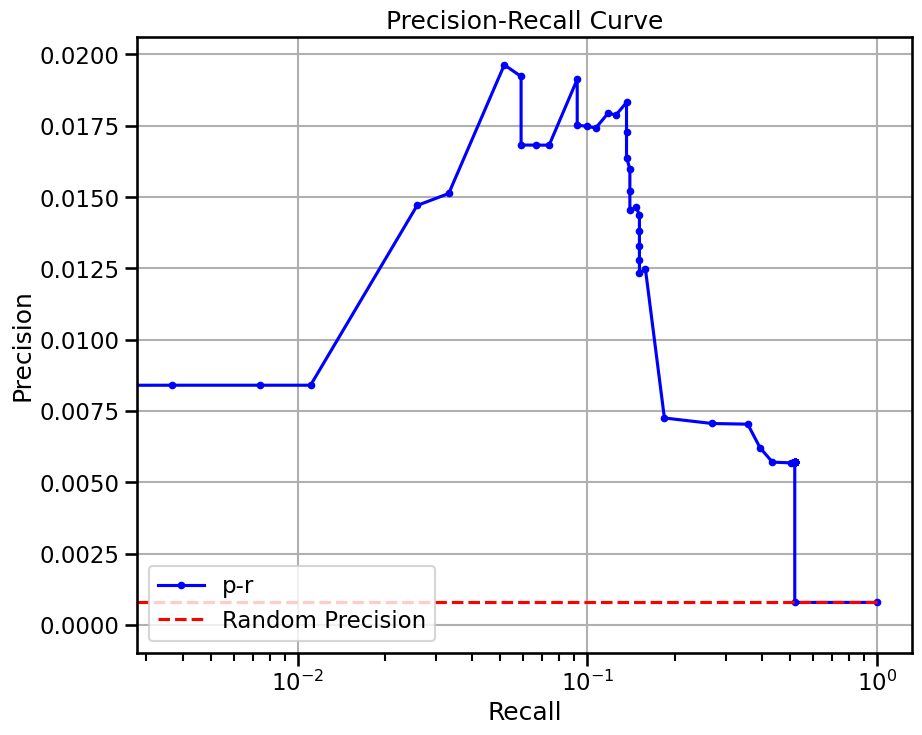

100%|██████████| 205/205 [03:01<00:00,  1.13it/s]


base enrichment
Top central genes: []


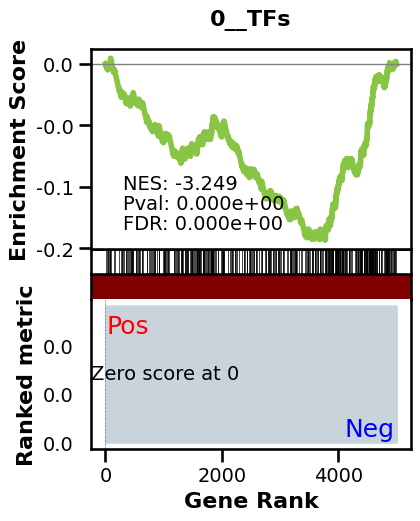

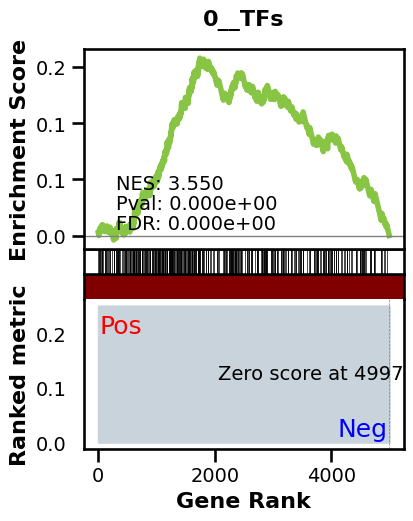

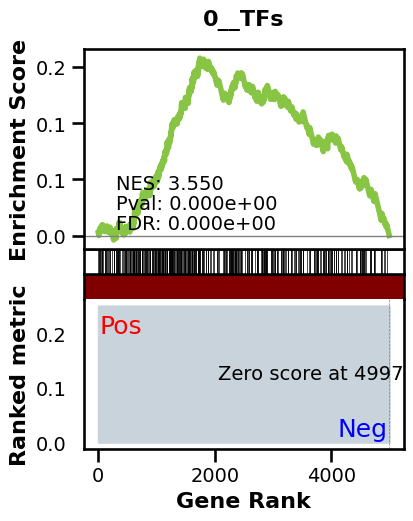

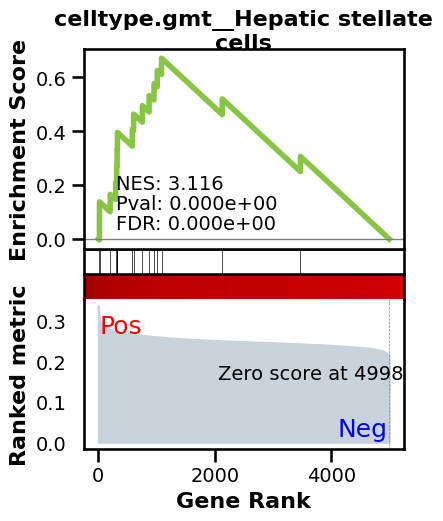

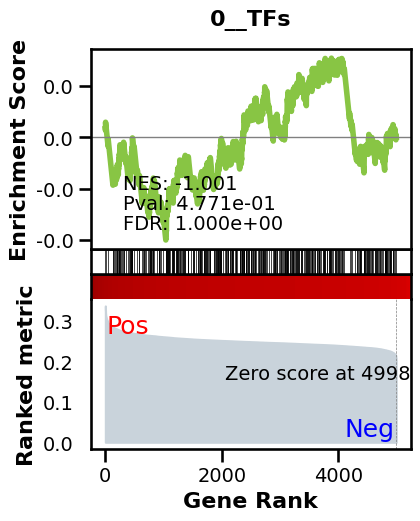

_________________________________________
TF specific enrichment
found some significant results for  13.793103448275861 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3633 genes
intersection pct: 0.7267453490698139
precision:  0.0013746819854608288 
recall:  1.0 
random precision: 0.0013750604771969137


100%|██████████| 128/128 [00:02<00:00, 44.53it/s]


Area Under Precision-Recall Curve (AUPRC):  0.0015359224318999875
EPR: 1.2433608048510763


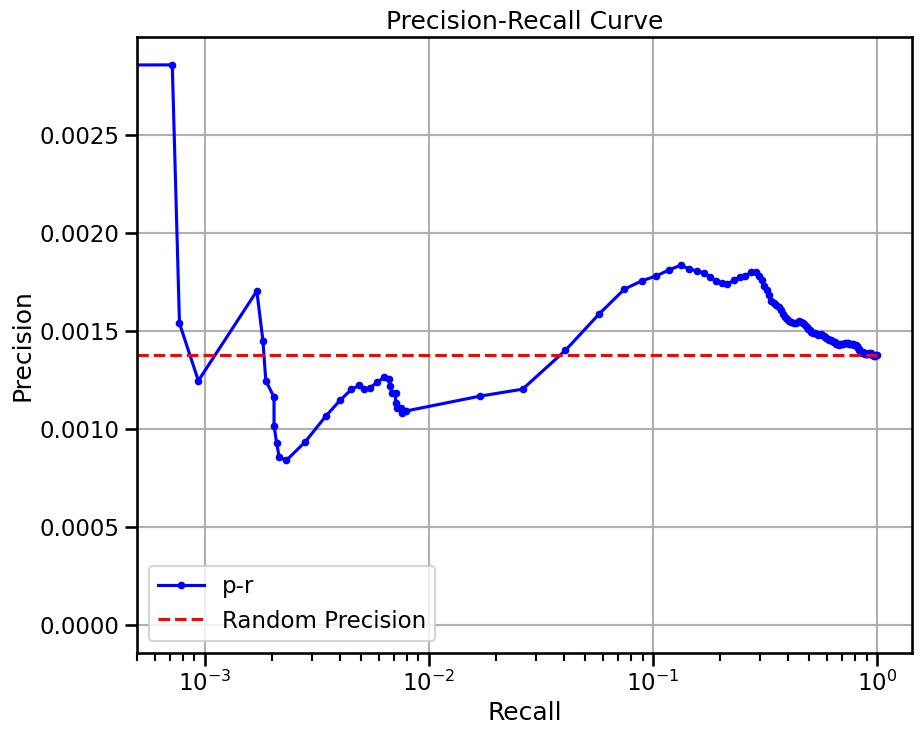

base enrichment
Top central genes: []


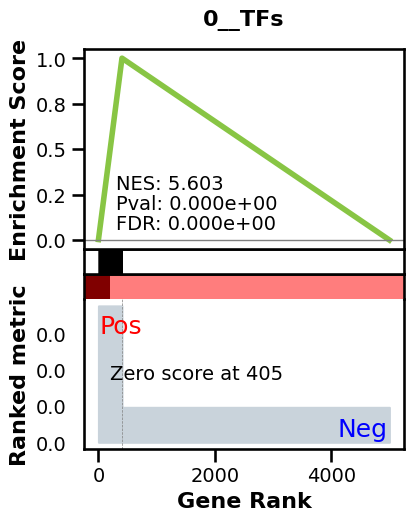

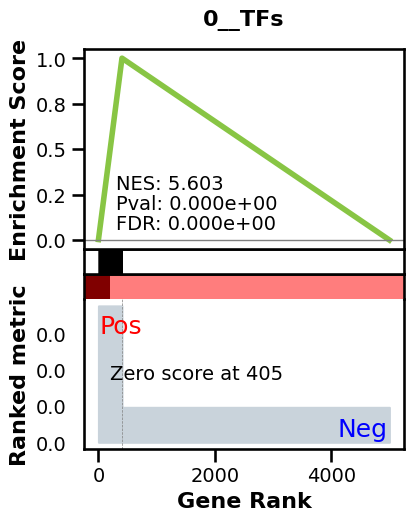

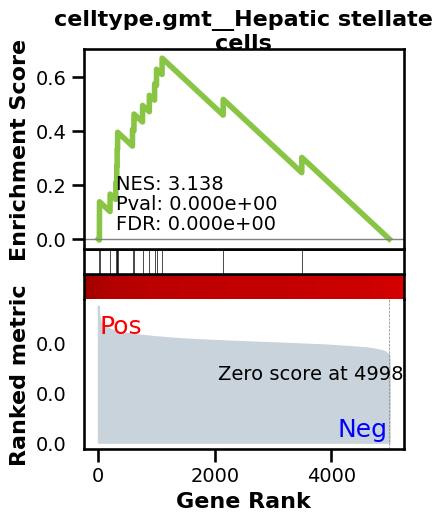

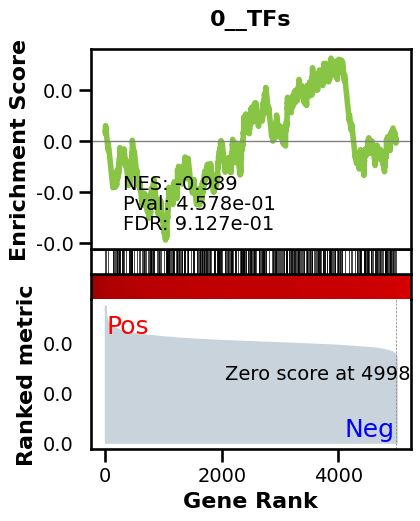

_________________________________________
TF specific enrichment
found some significant results for  1.7241379310344827 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3633 genes
intersection pct: 0.7267453490698139
precision:  0.0060602667637055805 
recall:  0.42956349206349204 
random precision: 0.0013750604771969137


100%|██████████| 128/128 [00:02<00:00, 46.71it/s]


Area Under Precision-Recall Curve (AUPRC):  0.0039773849050964
EPR: 5.395051665861319


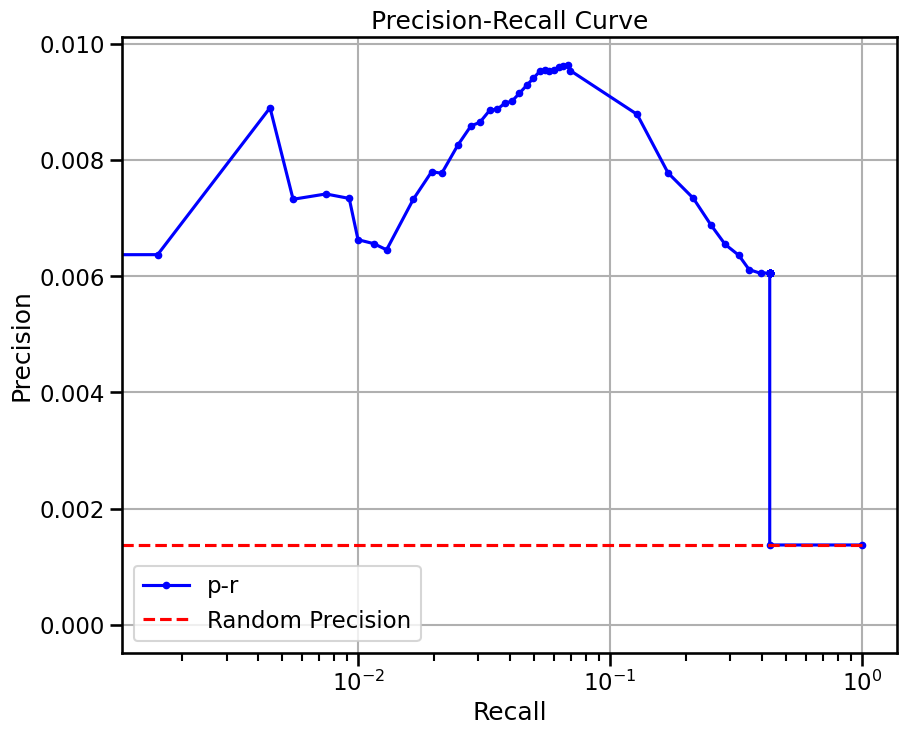

100%|██████████| 205/205 [03:13<00:00,  1.06it/s]


base enrichment
Top central genes: []


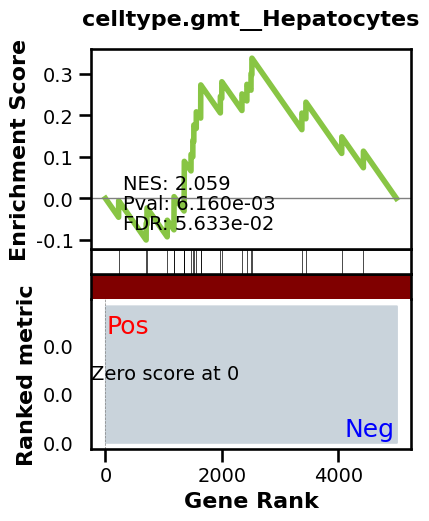

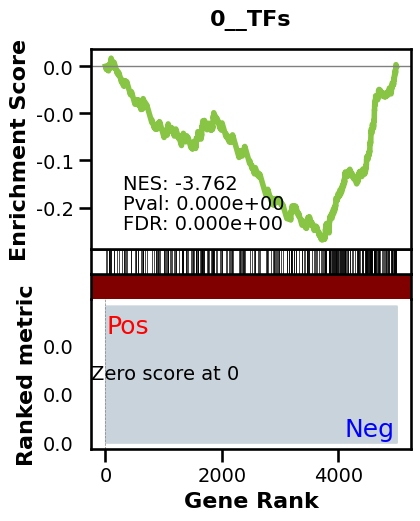

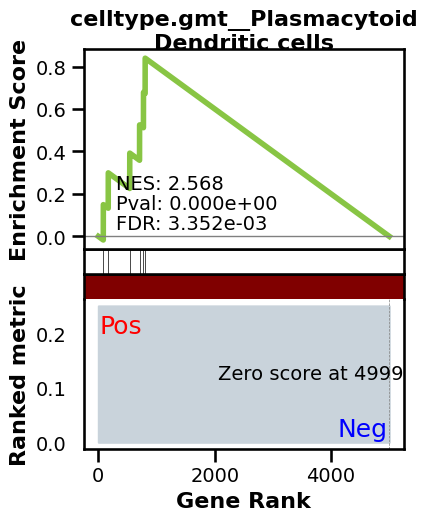

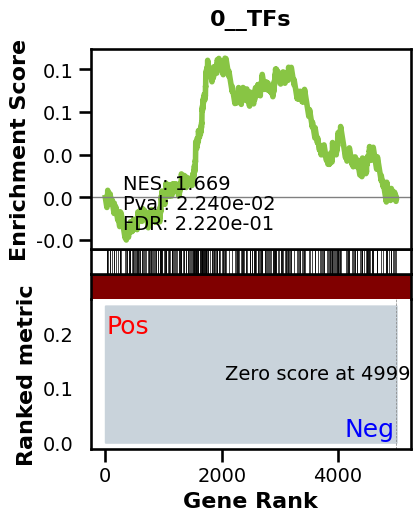

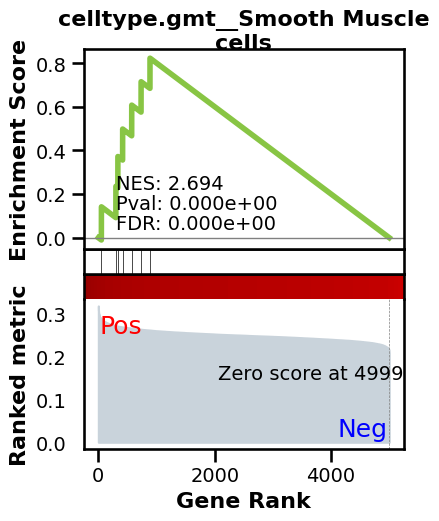

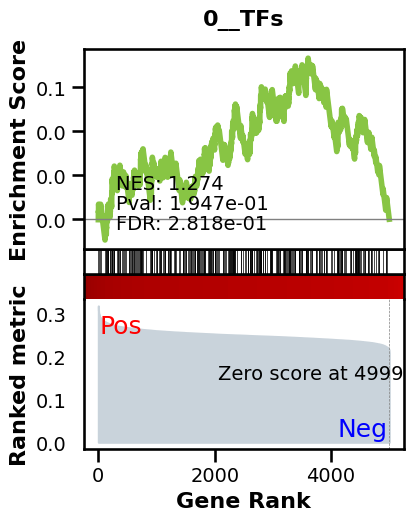

_________________________________________
TF specific enrichment
found some significant results for  7.142857142857143 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3599 genes
intersection pct: 0.7198
precision:  0.0008199770844931533 
recall:  1.0 
random precision: 0.0008202049825155249


100%|██████████| 128/128 [00:03<00:00, 42.62it/s]


Area Under Precision-Recall Curve (AUPRC):  0.0009328476373872425
EPR: 1.378360281338002


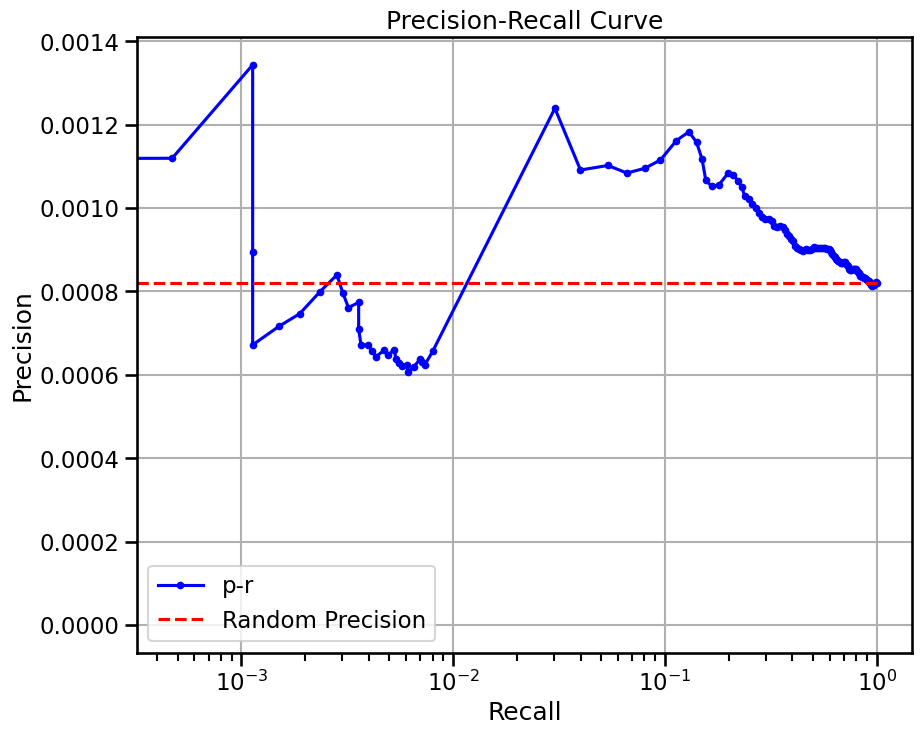

base enrichment
Top central genes: []


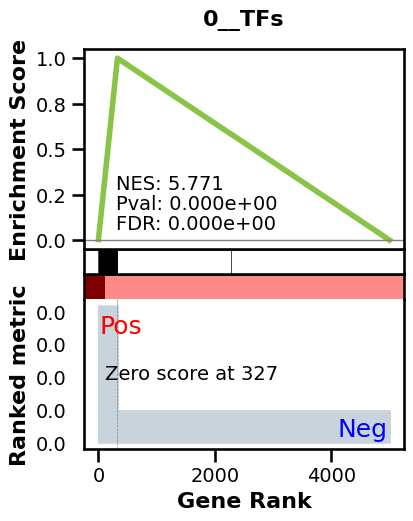

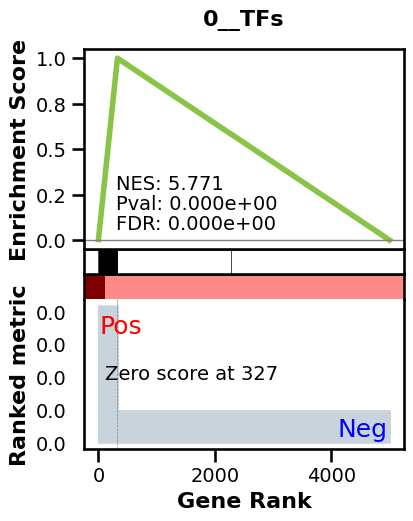

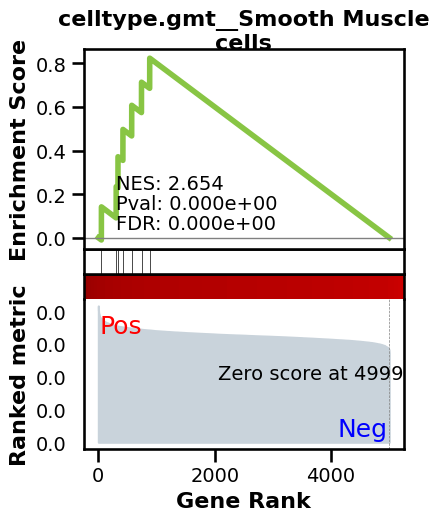

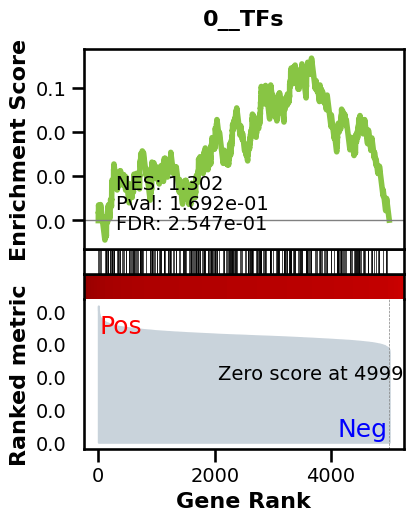

_________________________________________
TF specific enrichment
found some significant results for  7.142857142857143 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3599 genes
intersection pct: 0.7198
precision:  0.0028948151476276903 
recall:  0.2766217870257038 
random precision: 0.0008202049825155249


100%|██████████| 128/128 [00:03<00:00, 33.19it/s]


Area Under Precision-Recall Curve (AUPRC):  0.0015064534496368313
EPR: 4.502569264854277


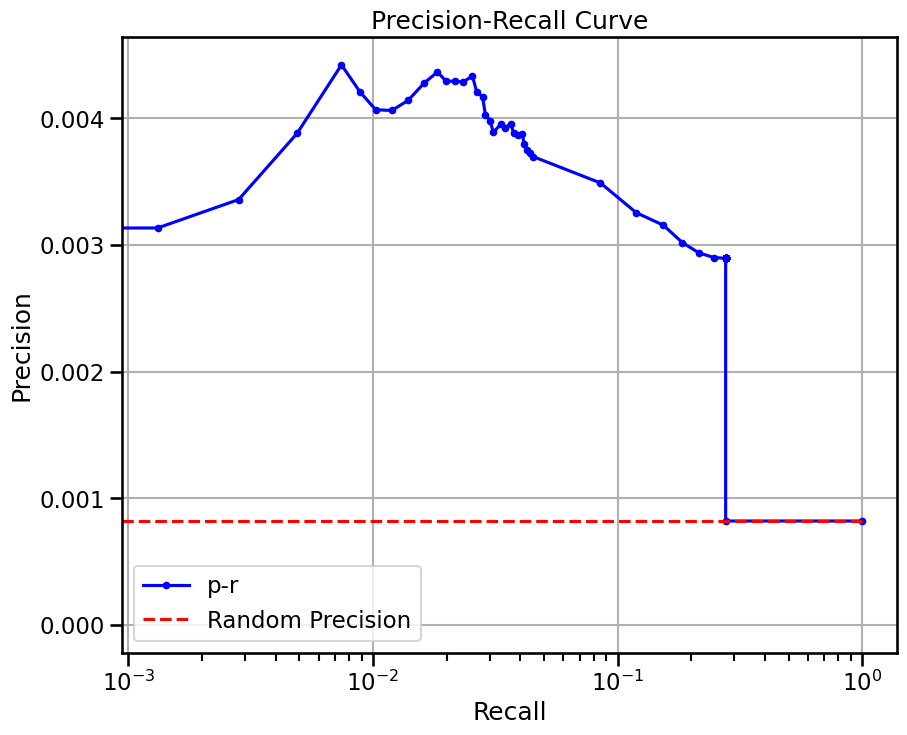

100%|██████████| 205/205 [01:24<00:00,  2.42it/s]


base enrichment
Top central genes: []


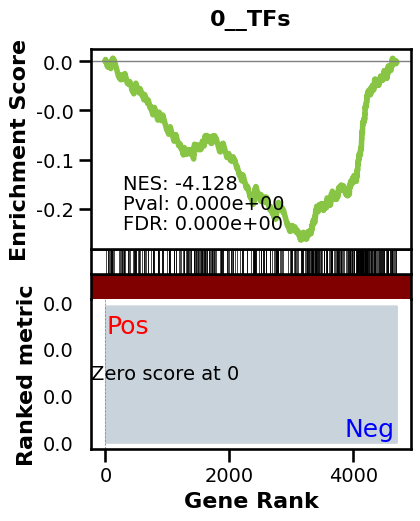

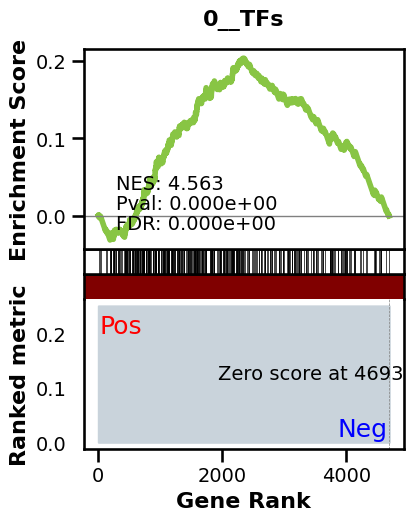

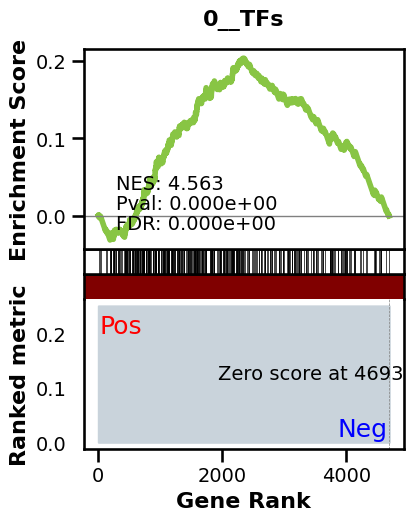

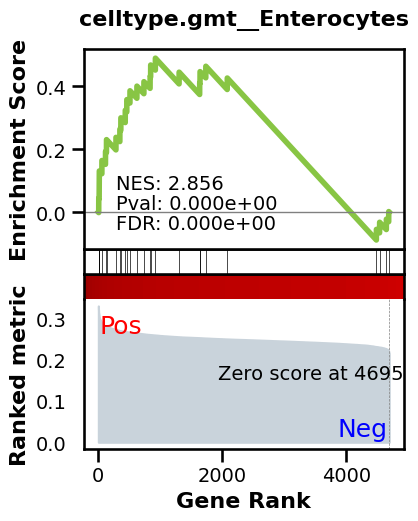

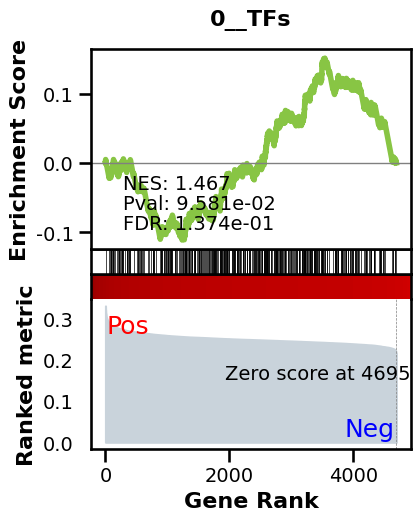

_________________________________________
TF specific enrichment
found some significant results for  10.714285714285714 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3190 genes
intersection pct: 0.6793015332197615
precision:  0.0006976149998525958 
recall:  1.0 
random precision: 0.0006978337565160805


100%|██████████| 128/128 [00:02<00:00, 52.94it/s]


Area Under Precision-Recall Curve (AUPRC):  0.0007773020049428632
EPR: 3.0365011050741906


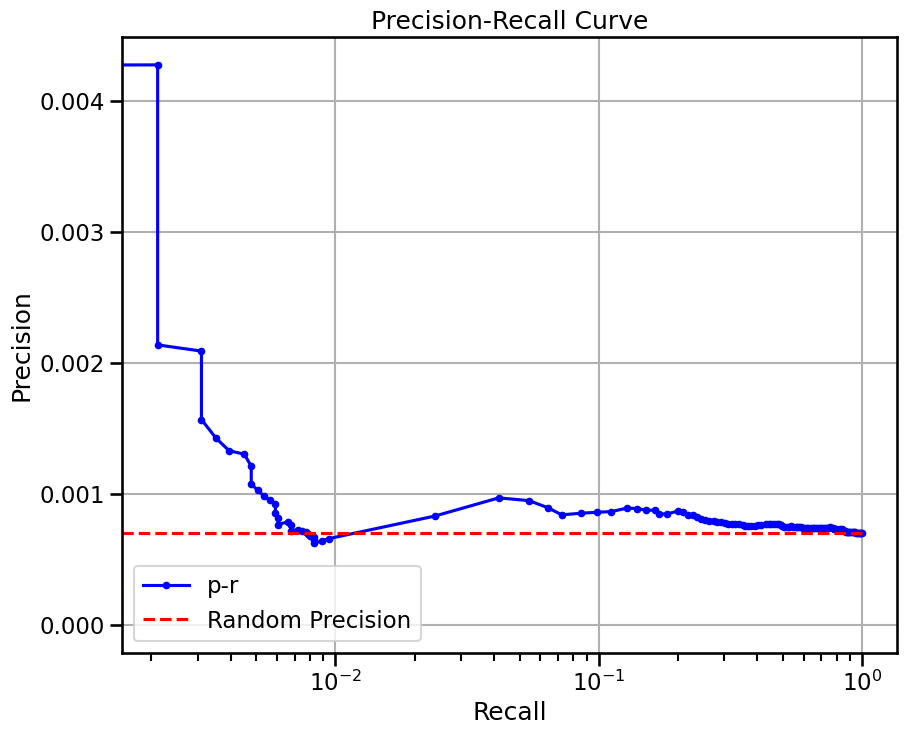

base enrichment
Top central genes: []


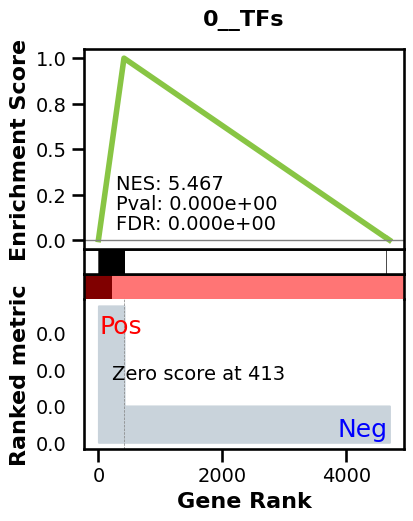

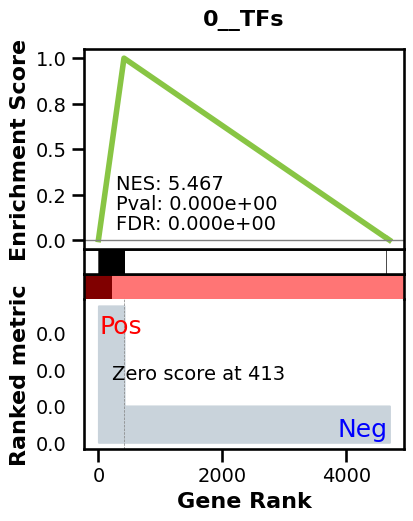

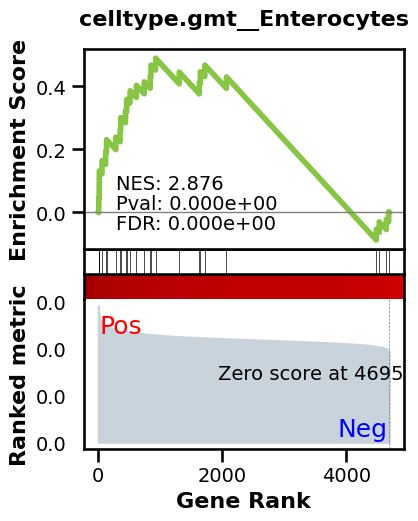

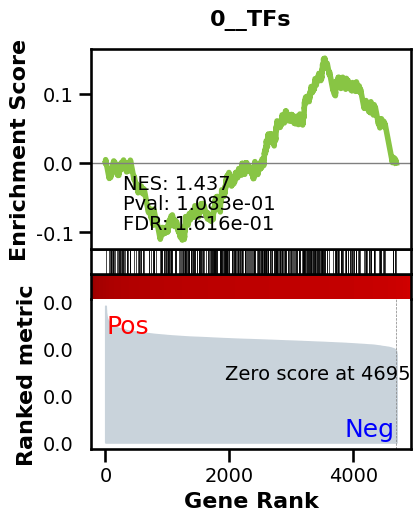

_________________________________________
TF specific enrichment
found some significant results for  3.5714285714285716 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3190 genes
intersection pct: 0.6793015332197615
precision:  0.0018386612893084586 
recall:  0.28835047189745033 
random precision: 0.0006978337565160805


100%|██████████| 128/128 [00:01<00:00, 65.37it/s]


Area Under Precision-Recall Curve (AUPRC):  0.0011410552177721326
EPR: 4.666505897689656


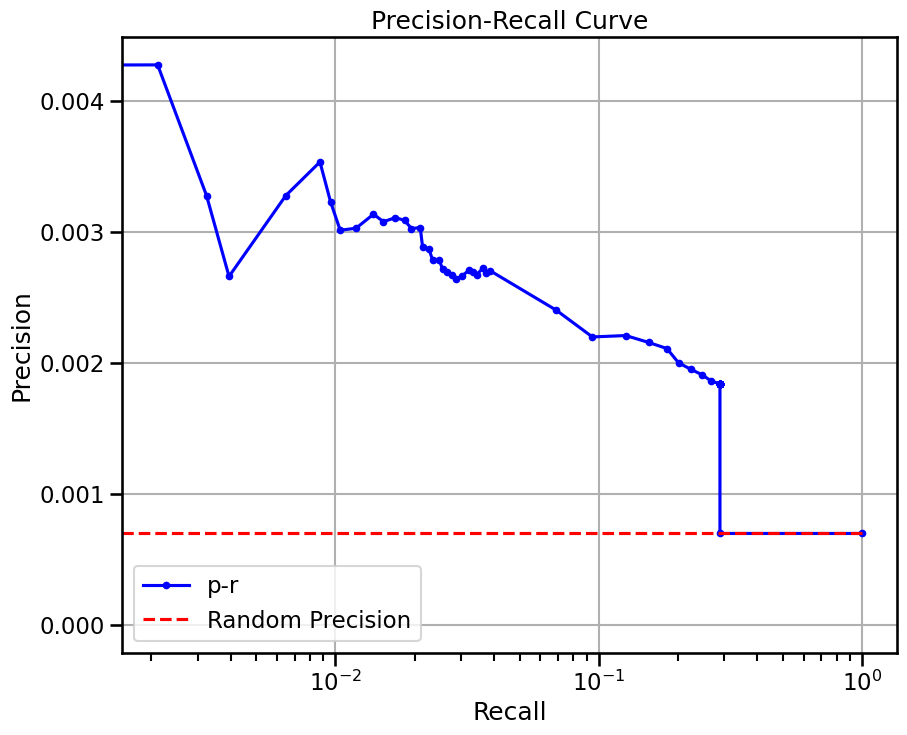

100%|██████████| 205/205 [01:20<00:00,  2.54it/s]


base enrichment
Top central genes: []


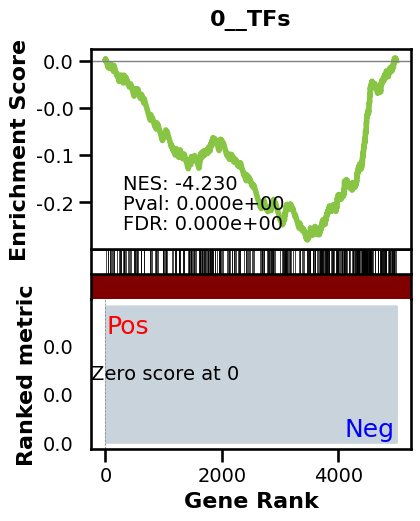

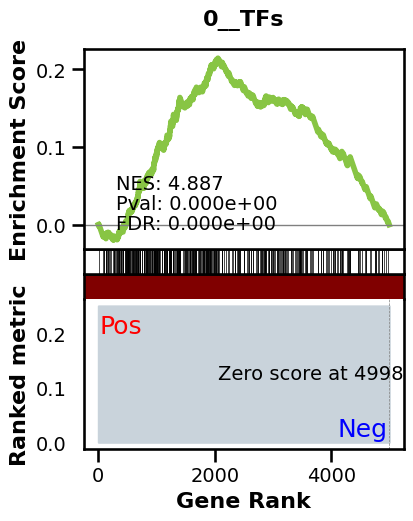

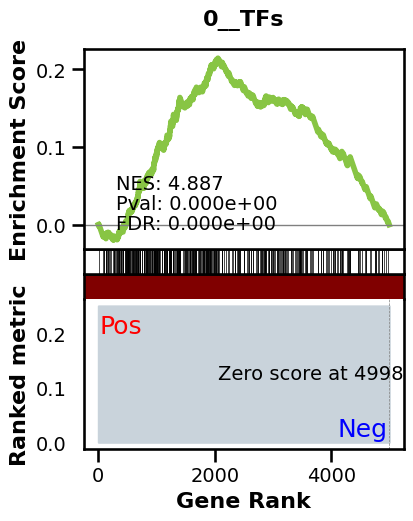

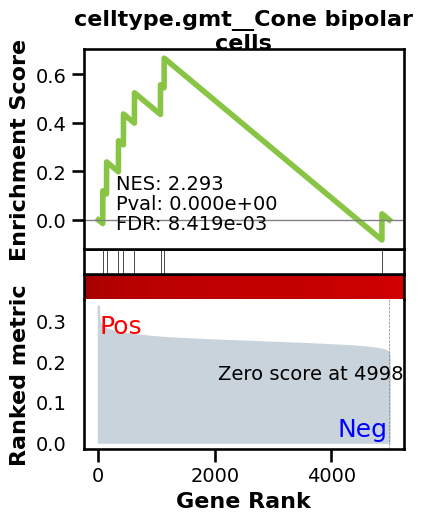

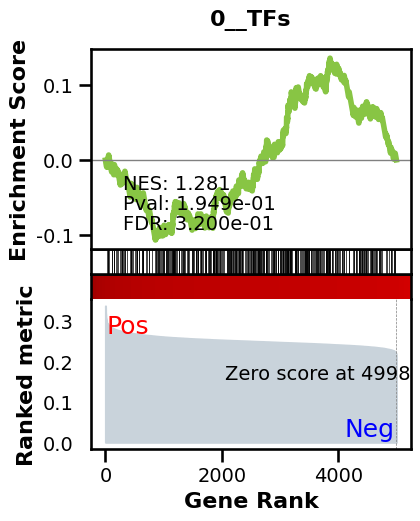

_________________________________________
TF specific enrichment
found some significant results for  10.714285714285714 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3520 genes
intersection pct: 0.7041408281656332
precision:  0.0006723753873966942 
recall:  1.0 
random precision: 0.0006725664574130047


100%|██████████| 128/128 [00:02<00:00, 53.63it/s]


Area Under Precision-Recall Curve (AUPRC):  0.0007664898307962315
EPR: 3.401892236811512


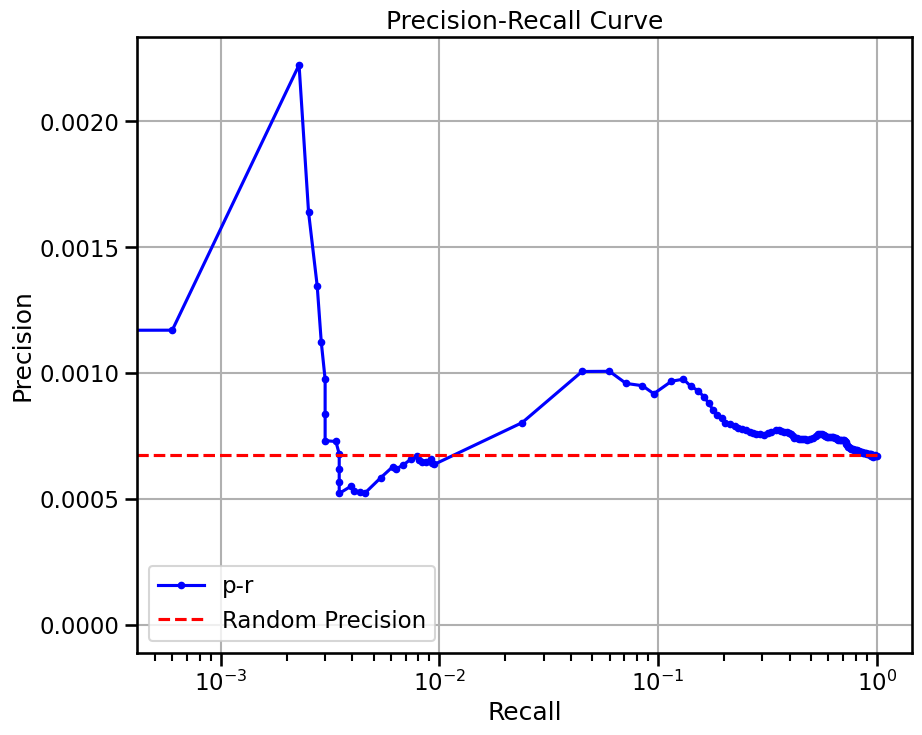

base enrichment
Top central genes: []


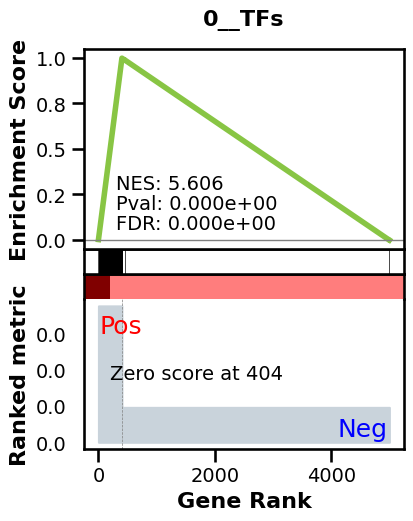

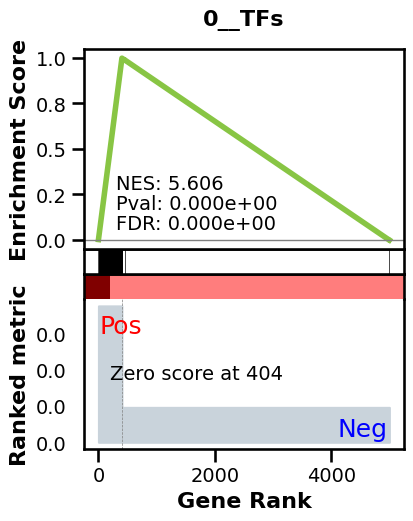

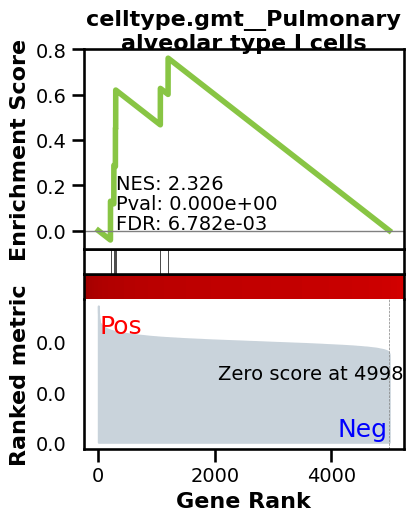

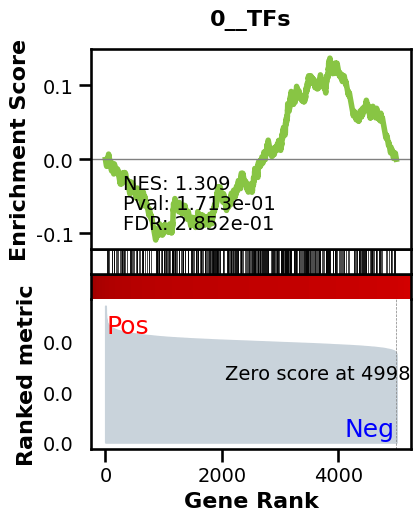

_________________________________________
TF specific enrichment
found some significant results for  17.857142857142858 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3520 genes
intersection pct: 0.7041408281656332
precision:  0.0016901718073593073 
recall:  0.23994718521185932 
random precision: 0.0006725664574130047


100%|██████████| 128/128 [00:02<00:00, 53.32it/s]


Area Under Precision-Recall Curve (AUPRC):  0.0010001551476084315
EPR: 3.401892236811512


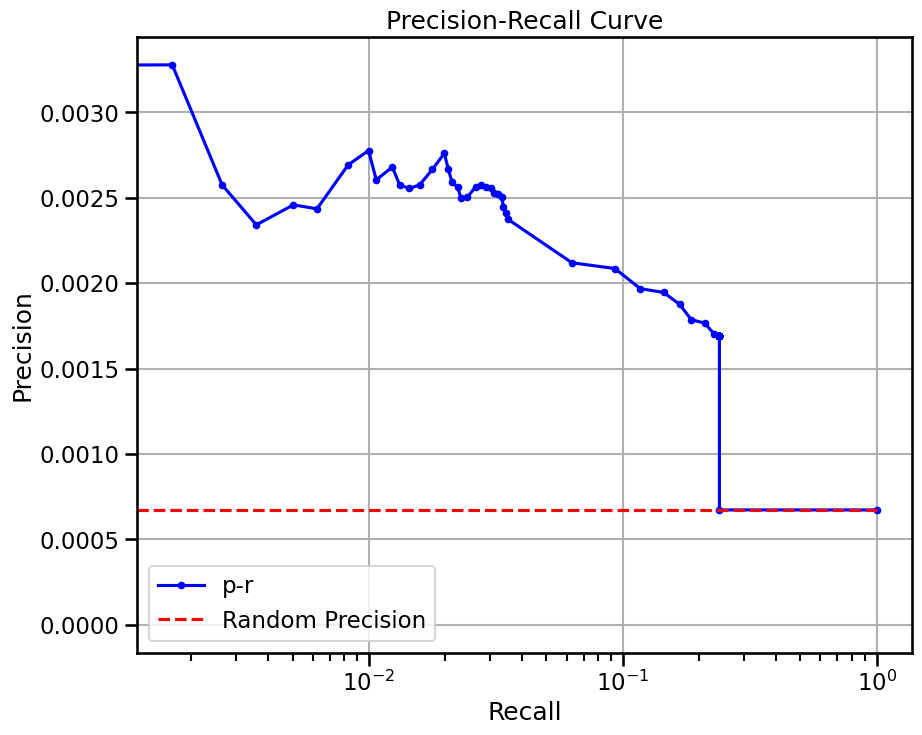

100%|██████████| 205/205 [03:12<00:00,  1.07it/s]


base enrichment
Top central genes: []


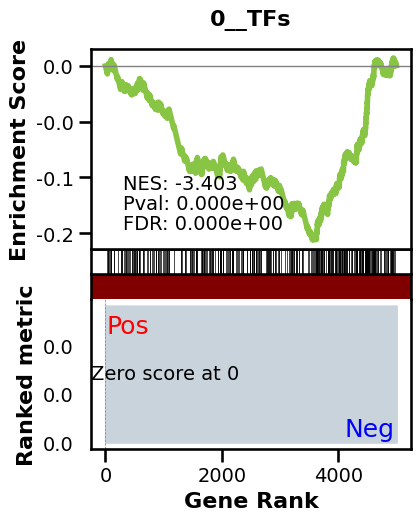

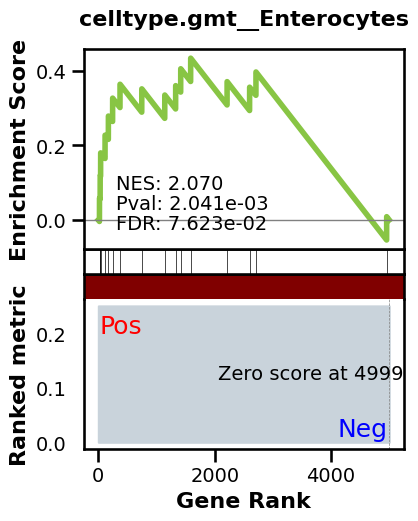

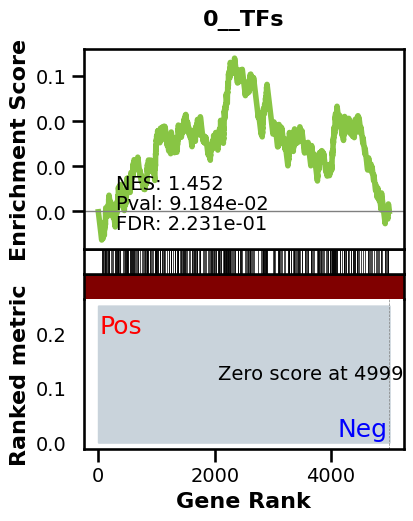

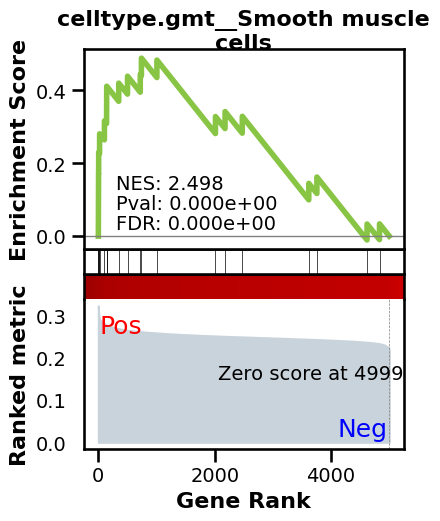

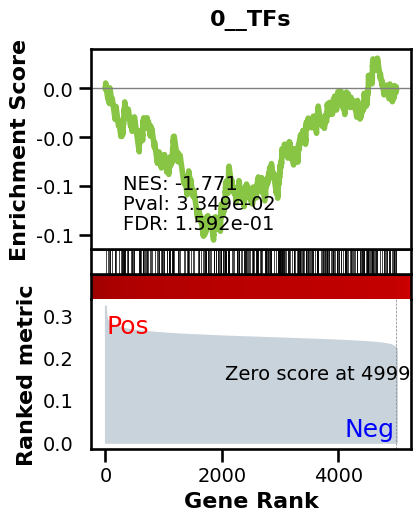

_________________________________________
TF specific enrichment
found some significant results for  15.151515151515152 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3522 genes
intersection pct: 0.7044
precision:  0.0007680287225167932 
recall:  1.0 
random precision: 0.0007682468505265962


100%|██████████| 128/128 [00:02<00:00, 53.33it/s]


Area Under Precision-Recall Curve (AUPRC):  0.0008251221929088776
EPR: 1.9154953675954216


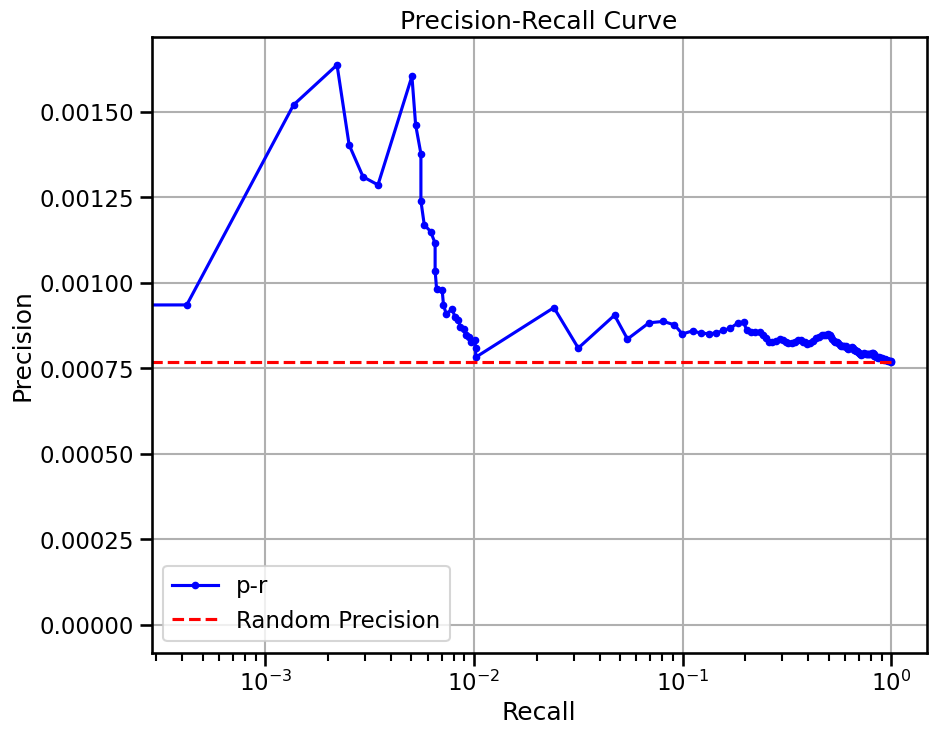

base enrichment
Top central genes: []


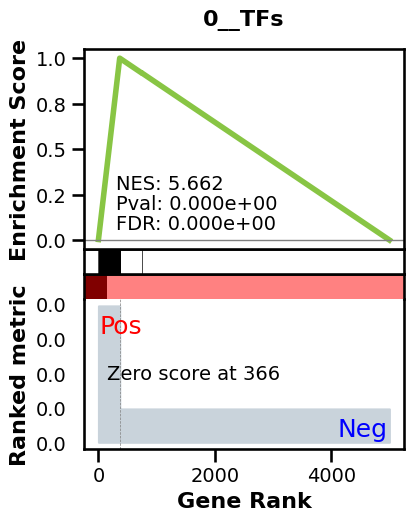

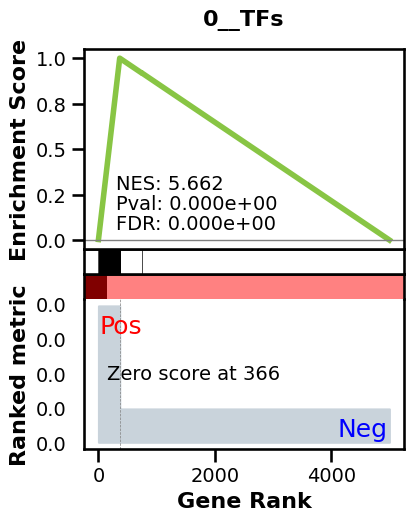

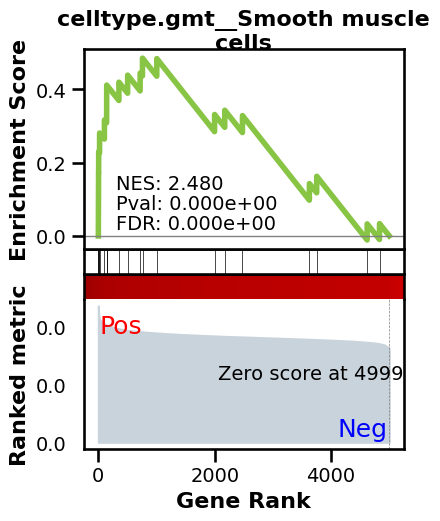

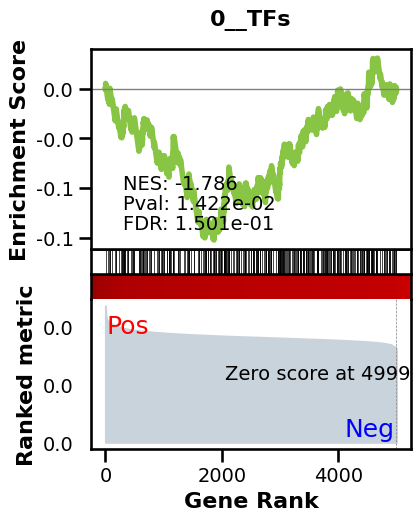

_________________________________________
TF specific enrichment
found some significant results for  6.0606060606060606 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3522 genes
intersection pct: 0.7044
precision:  0.002834563694870339 
recall:  0.31436968615513805 
random precision: 0.0007682468505265962


100%|██████████| 128/128 [00:02<00:00, 53.39it/s]


Area Under Precision-Recall Curve (AUPRC):  0.0014717817144594561
EPR: 4.671546978863012


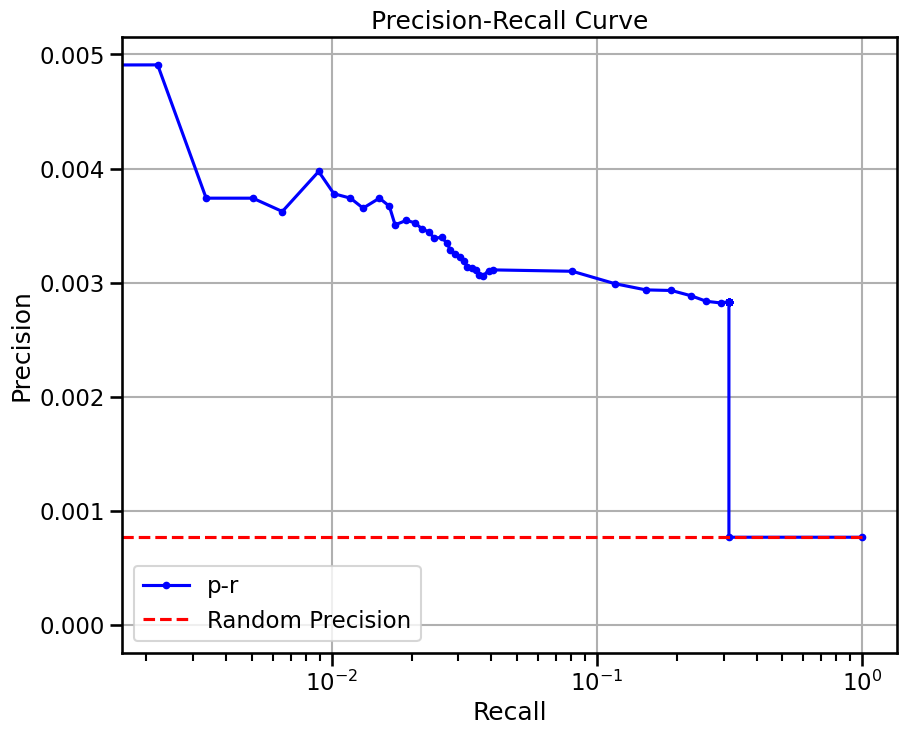

100%|██████████| 205/205 [03:20<00:00,  1.02it/s]


base enrichment
Top central genes: []


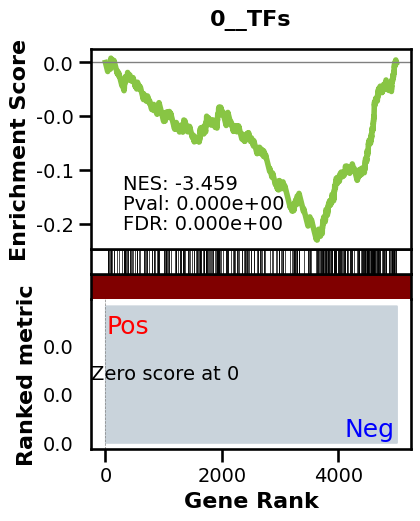

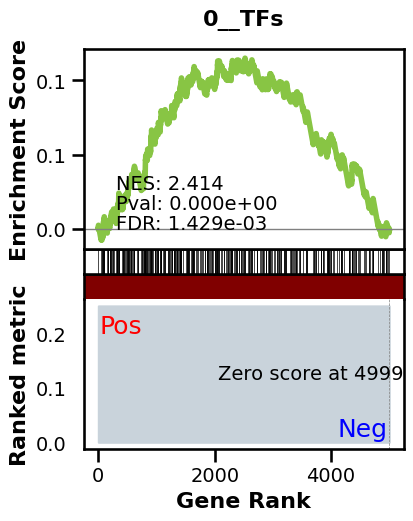

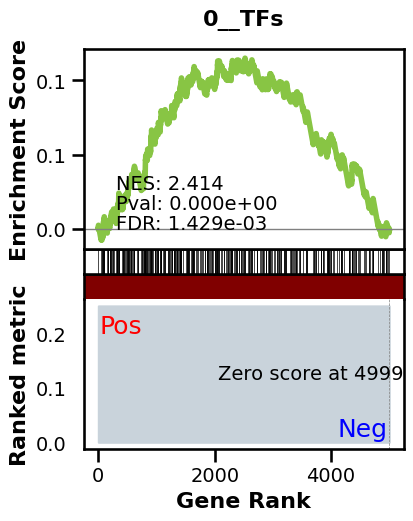

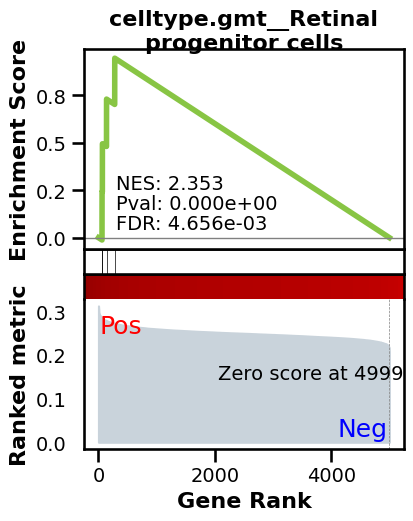

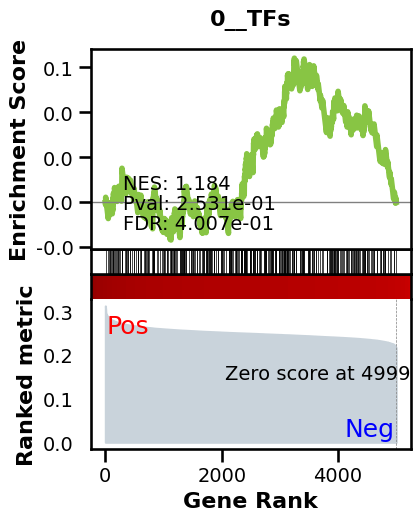

_________________________________________
TF specific enrichment
found some significant results for  19.23076923076923 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3550 genes
intersection pct: 0.71
precision:  0.0010244792699861138 
recall:  1.0 
random precision: 0.0010247679370106238


100%|██████████| 128/128 [00:02<00:00, 47.98it/s]


Area Under Precision-Recall Curve (AUPRC):  0.0011516831906021913
EPR: 0.5285583157555493


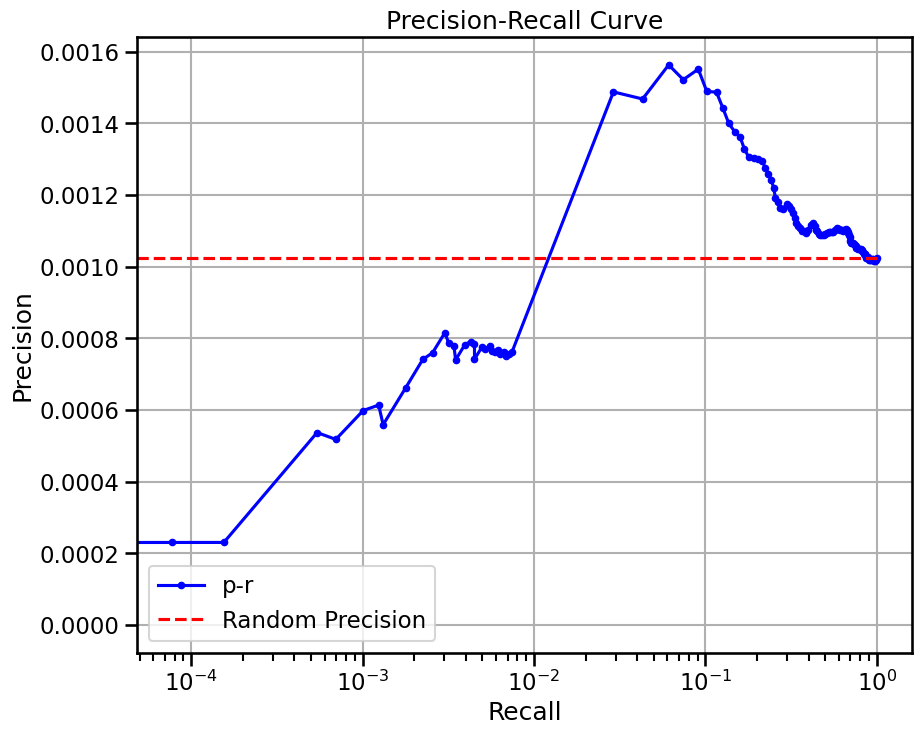

base enrichment
Top central genes: []


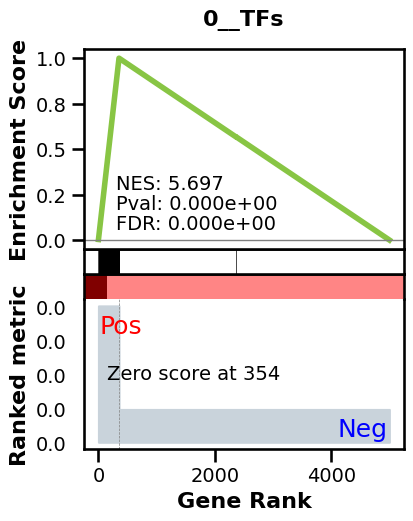

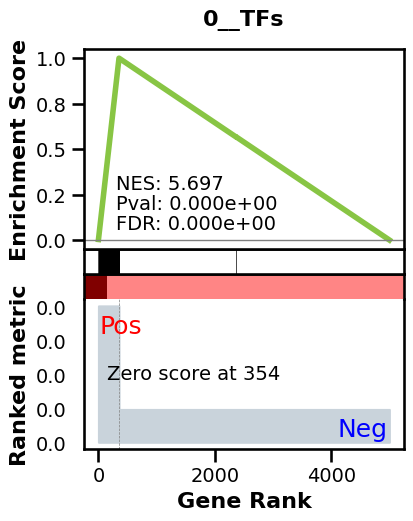

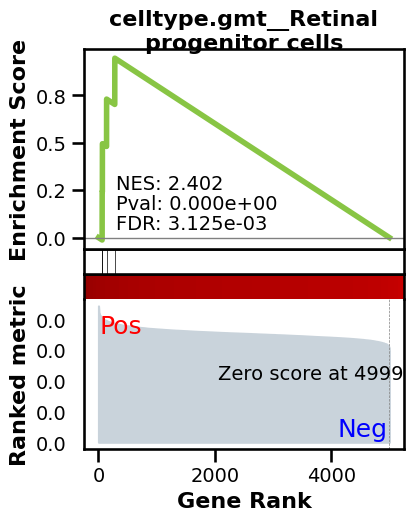

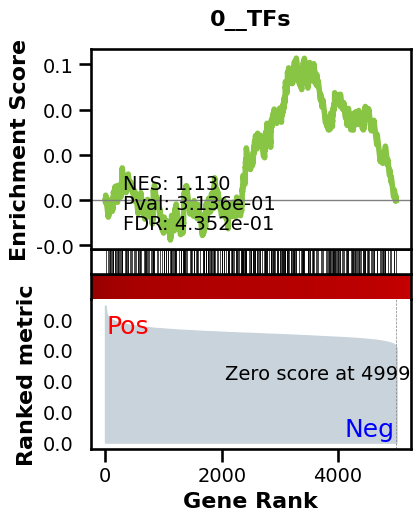

_________________________________________
TF specific enrichment
found some significant results for  11.538461538461538 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3550 genes
intersection pct: 0.71
precision:  0.003774647887323944 
recall:  0.3165517775540237 
random precision: 0.0010247679370106238


100%|██████████| 128/128 [00:02<00:00, 51.26it/s]


Area Under Precision-Recall Curve (AUPRC):  0.0020114985673581297
EPR: 4.1840435728353205


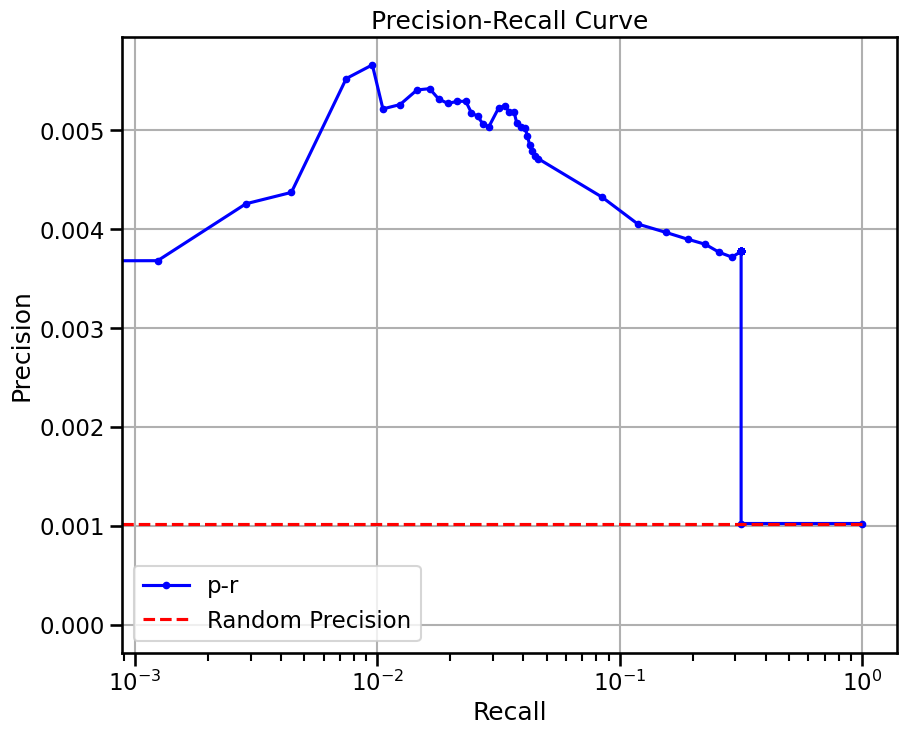

100%|██████████| 99/99 [01:31<00:00,  1.08it/s]


base enrichment
Top central genes: []


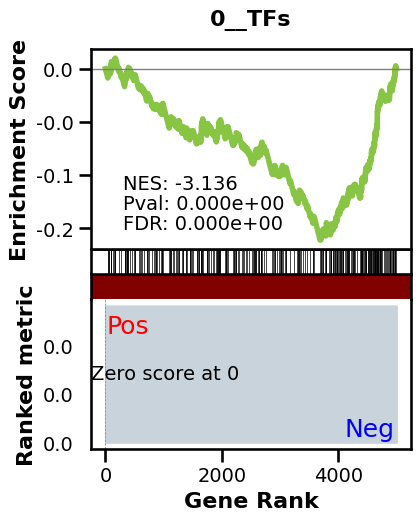

KeyboardInterrupt: 

In [7]:
sc.tl.rank_genes_groups(
    adata, groupby="cell_type"
)
adata.var['ensembl_id'] = adata.var.index
metrics = {}
for celltype in CELLTYPES:
    to_use = adata.uns["rank_genes_groups"]["names"][celltype].tolist()
    to_use = [i for i in to_use if i in genes]
    to_use = to_use[:NUM_GENES]
    subadata = adata[adata.obs.cell_type == celltype]
    subadata = subadata[subadata.X.sum(1) > 500][:MAXCELLS, adata.var.index.isin(to_use)]
    subadata.var = subadata.var.set_index('feature_name')
    grn = generate_grn(model, vocab, subadata, batch_size = 5, num_attn_layers = 11)
    metrics["scGPT_"+celltype] = BenGRN(grn).scprint_benchmark()
    grn.varp['GRN'][~grn.var.isTF,:]=0
    metrics['scGPT_tf_'+celltype] = BenGRN(grn).scprint_benchmark()
    gc.collect()
    torch.cuda.empty_cache()


In [22]:
torch.cuda.empty_cache()

In [24]:
grn = generate_grn(model, vocab, subadata, batch_size = 5, num_attn_layers = 11)

100%|██████████| 99/99 [01:35<00:00,  1.04it/s]


> /home/ml4ig1/Documents code/scGPT/mytests/scgpt_helper.py(170)generate_grn()
    168     # Default to 11, extraction from the last (12th) layer. Note that index starts from 0
    169 /home/ml4ig1/Documents code/scGPT/mytests/scgpt_helper.py(170)generate_grn()
    168     # Default to 11, extraction from the last (12th) layer. Note that index starts from 0
    169     model.eval()
--> 170     with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):
    171         M = all_gene_ids.size(1)
    172         N = all_gene_ids.size(0)

    165     dict_sum_condition = {}
    166     all_gene_ids, all_values, src_key_padding_mask, subadata = prepare_dataset(adata, vocab)
    167     # Use this argument to specify which layer to extract the attention weights from
    168     # Default to 11, extraction from the last (12th) layer. Note that index starts from 0
    169     model.eval()
--> 170     with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):
    171         M = all_gene_ids.

In [20]:
grn.varp['GRN'].sum(0).min()

0.2793926

In [ ]:
import pandas as pd

In [ ]:
res = []
for k, v in metrics.items():
    res.append([k.split('_')[-1], v['epr'], v['auprc'], v['rand_precision'], v['significant_enriched_TFtargets'], v.get('TF_enr', False), 'tf_' in k])

df = pd.DataFrame(res, columns=['name','EPR', 'AUPRC', 'RAND', 'TF_targ', 'TF_enr', 'TF_only'])
df